# Python notebook to plot apical region response to stimulation.
Assumes folder directory structure:
<pre><code>  IMAGING
    bftools
    image_stacks
    notebooks
</code></pre>
To verify results incrementally, execute the code one block at a time using &lt;shift-return&gt;.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage import exposure
from skimage.util import img_as_float32
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation
from skimage.morphology import label
from skimage.morphology import remove_small_objects

#### User editable parameters.
NOTE: Uncomment one file name.

In [2]:
# editable user parameters
#filename = "../image_stacks/Mistgcamp-3.oir"        # 1Hz
#filename = "../image_stacks/Mistgcamp-3_0001.oir"   # 2Hz
filename = "../image_stacks/Mistgcamp-3_0002.oir"   # 5Hz
#filename = "../image_stacks/Mistgcamp-3_0003.oir"   # 10Hz
image_bits = 10
roi_quantile = 0.98


#### Get the image stack.
Note: Takes about 12 seconds to run.

In [3]:
# get the image stack
!../bftools/bfconvert -overwrite {filename} temp.tiff
A0 = io.imread('temp.tiff')
A0 = np.float32(A0/(2.0**image_bits))
!rm temp.tiff

# average out y-direction aliasing over every other line
for n in range(A0.shape[0] - 1): # moving average over every two lines
  A0[n] = (A0[n] + A0[n+1]) / 2.0


../image_stacks/Mistgcamp-3_0002.oir
OIRReader initializing ../image_stacks/Mistgcamp-3_0002.oir
Reading pixel blocks from /Users/jrug001/Desktop/nesi00119/plot_apical/IMAGING/notebooks/../image_stacks/Mistgcamp-3_0002.oir
[Olympus OIR] -> temp.tiff [Tagged Image File Format]
	Converted 28/300 planes (9%)
	Converted 65/300 planes (21%)
	Converted 101/300 planes (33%)
	Converted 140/300 planes (46%)
	Converted 182/300 planes (60%)
	Converted 222/300 planes (74%)
	Converted 262/300 planes (87%)
	Converted 300/300 planes (100%)
[done]
11.672s elapsed (3.0033333+23.163334ms per plane, 3639ms overhead)


#### Unstimulated average over time.


In [5]:
!echo $PATH

/usr/local/opt/sqlite3/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/X11/bin


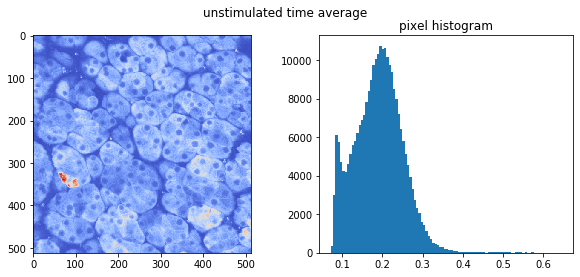

In [17]:
# unstimulated average over time
A = np.concatenate((A0[:100,:,:], A0[249:,:,:])) # unstimulated only
M = np.zeros(A[0].shape)
for n in range(A.shape[0]): # average over time
  M += A[n]
M /= A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('unstimulated time average')
ax[0].imshow(M, norm=None, cmap='coolwarm') # image
ax[1].hist(M.flatten(), bins=100) # histogram
plt.title("pixel histogram")
plt.show()


#### Stimulated average over time.


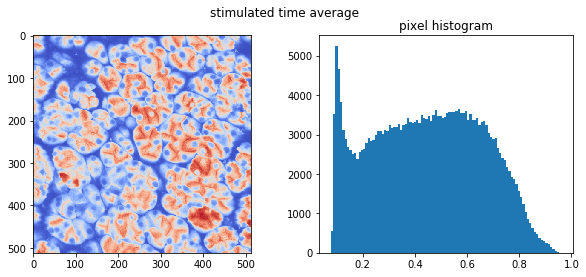

In [18]:
# stimulated average over time
A = A0[101:248,:,:] # stimulated only
N = np.zeros(A[0].shape)
for n in range(A.shape[0]): # average over time
  N += A[n]
N /= A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('stimulated time average')
ax[0].imshow(N, norm=None, cmap='coolwarm') # image
ax[1].hist(N.flatten(), bins=100) # histogram
plt.title("pixel histogram")
plt.show()


#### Stimulated minus unstimulated average over time.


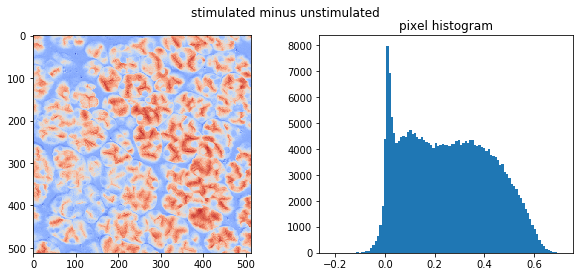

In [19]:
# difference: stimulated - unstimulated
O = N - M

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('stimulated minus unstimulated')
ax[0].imshow(O, norm=None, cmap='coolwarm') # image
ax[1].hist(O.flatten(), bins=100) # histogram
plt.title("pixel histogram")
plt.show()


#### Create apical region-of-interest mask.


number of apical regions identified:  15
apical ROI values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
apical ROI pixel counts:  [ 72 160 227  84  52 104 102 225  97 174  80  60  59 450 169]



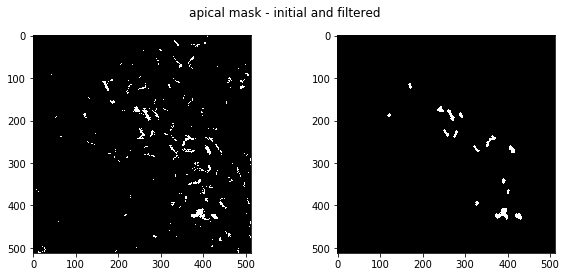

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('apical mask - initial and filtered')

# difference threashold filter
P = (O > np.quantile(O,roi_quantile)).astype(float)

# plot image
ax[0].imshow(P, norm=None, cmap='gray');

# filtering: remove small, then thicken
Q = binary_erosion(P)
Q = remove_small_objects(Q, 16)
Q = binary_dilation(Q)
Q = binary_dilation(Q)
ax[1].imshow(Q, norm=None, cmap='gray') # plot image

# label and get pixel counts
Q, n = label(Q, return_num=True)
ROI, COUNT = np.unique(Q, return_counts=True)
print("number of apical regions identified: ", ROI.shape[0]-1)
print("apical ROI values: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])
print()

#### Plot apical region responses to stimulus.


*********************************************************************
 plots for ../image_stacks/Mistgcamp-3_0003.oir
*********************************************************************



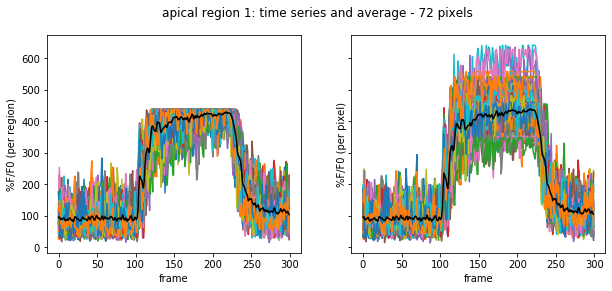

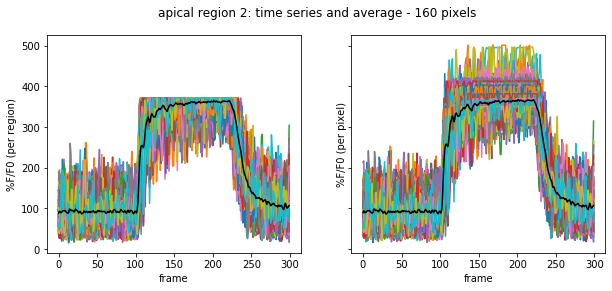

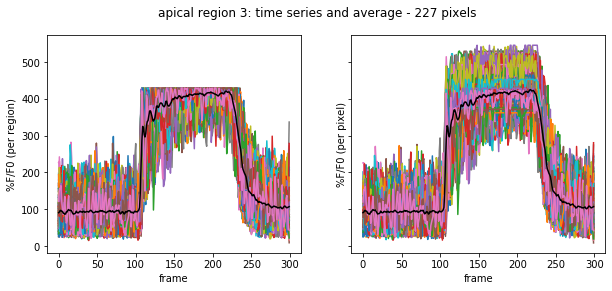

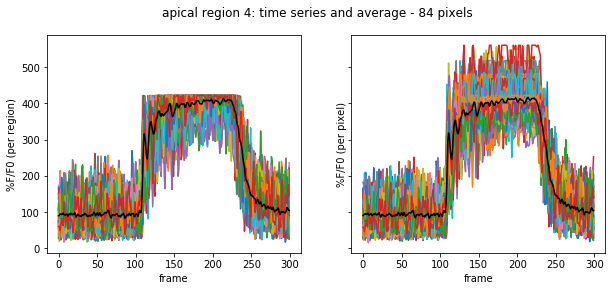

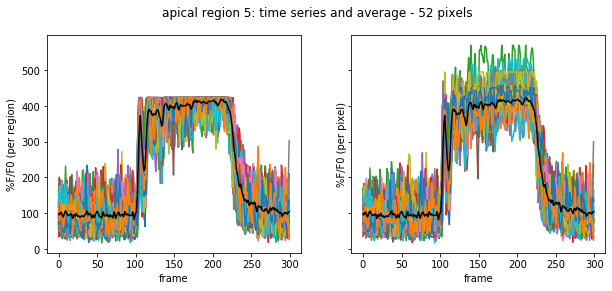

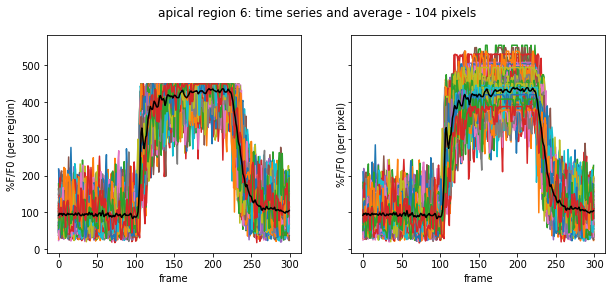

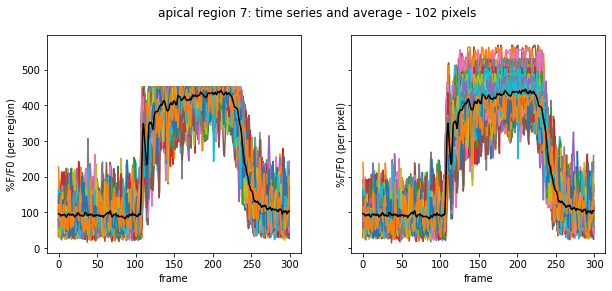

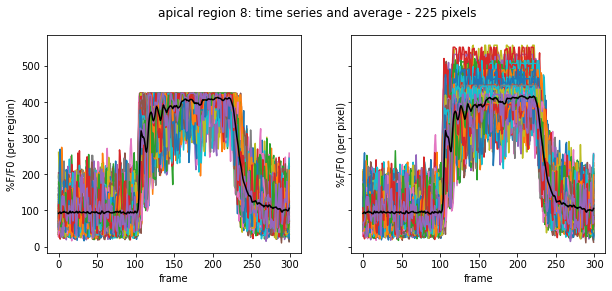

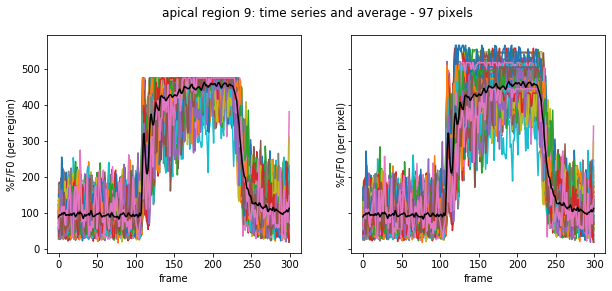

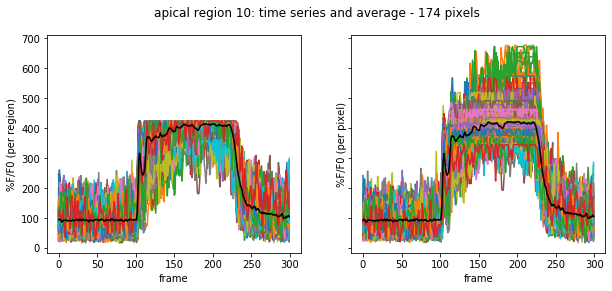

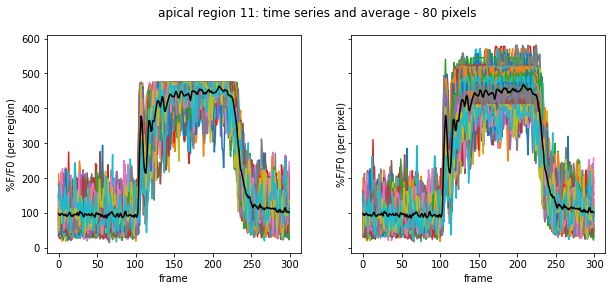

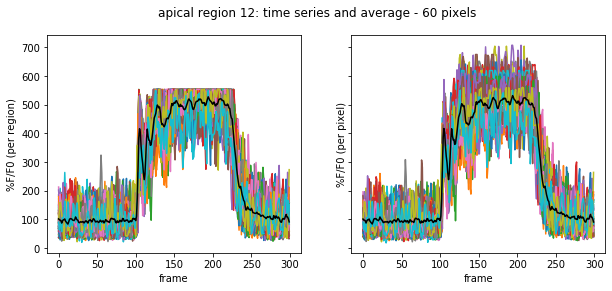

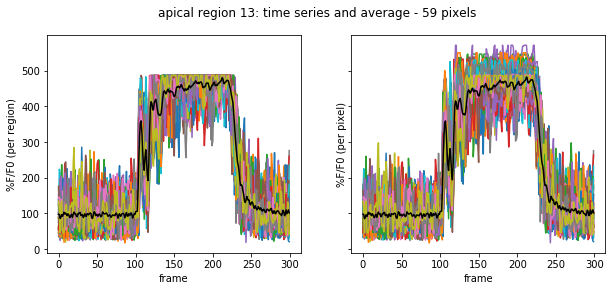

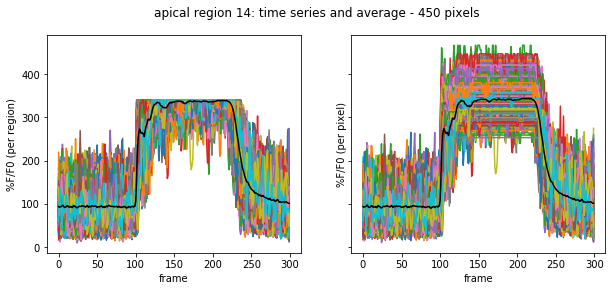

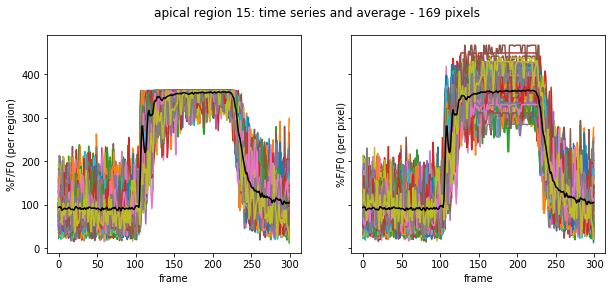

In [21]:
# apical region plots

print("*********************************************************************")
print(" plots for " + filename)
print("*********************************************************************")
print()
for c in ROI:
  if(c==0):
    continue
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4], sharey=True)
  fig.suptitle('apical region ' + str(c)+ ": time series and average" + " - " +str(COUNT[c]) + " pixels")

  # F0 per region
  F0 = np.average(M[Q==ROI[c]]) 
  S = 100 * A0[:, Q==ROI[c]] / F0
  T = np.sum(S, axis=1) / S.shape[1]
  ax[0].plot(S)
  ax[0].plot(T, color='black')
  ax[0].set(ylabel="%F/F0 (per region)")
  ax[0].set(xlabel="frame")

  # F0 per pixel
  F0 = M[Q==ROI[c]] 
  S = 100 * A0[:, Q==ROI[c]] / F0
  T = np.sum(S, axis=1) / S.shape[1]
  ax[1].plot(S)
  ax[1].plot(T, color='black')
  ax[1].set(ylabel="%F/F0 (per pixel)")
  ax[1].set(xlabel="frame")
